In [ ]:
"""AI Final Group 9
Wumpus World 
Value Iteration: 
Hagop Tanashian
Emanuel Ruiz
Matthew Chung
Steven Nguyen

""" 

import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from time import time
from enum import Enum 



class WumpusWorld:
  def __init__(self, filename, reward, random_rate, time_limit= 1000):
    file = open(filename)
    self.map = np.array(
        [list(map(float, s.strip().split(","))) for s in file.readlines()]
    )
    file.close()
    self.num_rows = self.map.shape[0]
    self.num_cols = self.map.shape[1]
    self.num_states = self.num_rows * self.num_cols
    self.num_actions = 4
    self.reward = reward
    self.random_rate = random_rate
    self.time_limit = time_limit
    self.reward_function = self.get_reward_function()
    self.transition_model = self.get_transition_model()

  
  def get_State_From_Position(self, pos):
    return pos[0] * self.num_cols + pos[1]

  def get_Position_From_State(self, state):
    return state // self.num_cols, state % self.num_cols

  def get_reward_function(self):
    # create a table that will hold the rewards
    reward_table = np.zeros(self.num_states)
     
    for row in range(self.num_rows):
      for col in range(self.num_cols):
        #loop through all states
        state = self.get_State_From_Position((row,col))
        #and set the reward according to the value stored in the map at position state
        #using the reward dictionary passed in
        reward_table[state] = self.reward[self.map[row,col]]
    return reward_table
  
  # will create a 3D array with all possible actions for each state
  def get_transition_model(self):
    transition_model = np.zeros((self.num_states, self.num_actions, self.num_states))
    for row in range(self.num_rows):
      for col in range(self.num_cols):
        state = self.get_State_From_Position((row, col))
        state_neighbors = np.zeros(self.num_actions)
         
        if self.map[row,col] == 0:
          #Move through all actions and neighbors
          for action in range(self.num_actions):
            new_row, new_col = row, col
            if action == 0:
              new_row = max(row-1, 0)
            elif action == 1:
              new_col = min(col + 1, self.num_actions - 1)
            elif action == 2:
              new_row = min(row + 1, self.num_rows-1)
            elif action == 3:
              new_col = max(col-1, 0)
            #Check that the value is not a blocked off state
            if self.map[(new_row,new_col)] == 3:
              new_row, new_col = row, col
            
            state_prime = self.get_State_From_Position((new_row, new_col))
            state_neighbors[action] = state_prime 
        #else the value is either the Wumpus, Blocked of state, or the gold
        else:
          #at which point the neighbors are itself
          state_neighbors = np.ones(self.num_actions) * state  
        
        #update the transitions probabilities for a specific state and action,
        #based on the probabliities of transitioning to neighboring states
        for action  in range(self.num_actions): 
          transition_model[state, action, int(state_neighbors[action])] += 1 - self.random_rate
          transition_model[state, action, int(state_neighbors[(action + 1)% self.num_actions])] += self.random_rate/2.0
          transition_model[state, action, int(state_neighbors[(action -1)% self.num_actions])] += self.random_rate/2.0
    return transition_model

  

 
  def visualize_value_policy(self, policy, values, fig_size=(8, 6)):
        unit = min(fig_size[1] // self.num_rows, fig_size[0] // self.num_cols)
        unit = max(1, unit)
        fig, ax = plt.subplots(1, 1, figsize=fig_size)
        ax.axis('off')

        for i in range(self.num_cols + 1):
            if i == 0 or i == self.num_cols:
                ax.plot([i * unit, i * unit], [0, self.num_rows * unit],
                        color='black')
            else:
                ax.plot([i * unit, i * unit], [0, self.num_rows * unit],
                        alpha=0.7, color='grey', linestyle='dashed')
        for i in range(self.num_rows + 1):
            if i == 0 or i == self.num_rows:
                ax.plot([0, self.num_cols * unit], [i * unit, i * unit],
                        color='black')
            else:
                ax.plot([0, self.num_cols * unit], [i * unit, i * unit],
                        alpha=0.7, color='grey', linestyle='dashed')

        for i in range(self.num_rows):
            for j in range(self.num_cols):
                y = (self.num_rows - 1 - i) * unit
                x = j * unit
                s = self.get_State_From_Position((i, j))
                if self.map[i, j] == 3:
                    rect = patches.Rectangle((x, y), unit, unit, edgecolor='none', facecolor='black',
                                             alpha=0.6)
                    ax.add_patch(rect)
                elif self.map[i, j] == 2:
                    rect = patches.Rectangle((x, y), unit, unit, edgecolor='none', facecolor='red',
                                             alpha=0.6)
                    ax.add_patch(rect)
                elif self.map[i, j] == 1:
                    rect = patches.Rectangle((x, y), unit, unit, edgecolor='none', facecolor='green',
                                             alpha=0.6)
                    ax.add_patch(rect)
                if self.map[i, j] != 3:
                    ax.text(x + 0.5 * unit, y + 0.5 * unit, f'{values[s]:.4f}',
                            horizontalalignment='center', verticalalignment='center',
                            fontsize=max(fig_size)*unit*0.6)
                if policy is not None:
                    if self.map[i, j] == 0:
                        a = policy[s]
                        symbol = ['^', '>', 'v', '<']
                        ax.plot([x + 0.5 * unit], [y + 0.5 * unit], marker=symbol[a], alpha=0.4,
                                linestyle='none', markersize=max(fig_size)*unit, color='#1f77b4')

        plt.tight_layout()
        plt.show()









In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class ValuteIteration:
  def __init__(self, reward_function, transition_model, gamma):
    self.num_states = transition_model.shape[0]
    self.num_actions = transition_model.shape[1]
    self.reward_function = np.nan_to_num(reward_function)
    self.transition_model = transition_model
    self.gamma = gamma
    self.values = np.zeros(self.num_states)

  def one_iteration(self):
    #difference between previous value and current value
    delta = 0
  
    for state in range(self.num_states):
      temp = self.values[state]
      #create an action value list
      value_list = np.zeros(self.num_actions)
      for action in range(self.num_actions):
        #get the probability list of all states, taking action from current state
        probability = self.transition_model[state, action]
        #use the bellman equation to calculate the sum value of taking current action
        value_list[action]= self.reward_function[state] + self.gamma *np.sum(probability * self.values)
      #set the value of the state as the best action outcome
      self.values[state] = max(value_list)
      #get the delta of the highest difference
      delta = max(delta, abs(temp - self.values[state]))

    return delta
  
  #Get policy choosing the max action for each state
  def get_policy(self):
    policy = np.ones(self.num_states) * -1
    for state in range(self.num_states):
      values_list = np.zeros(self.num_actions)
      for action in range(self.num_actions):
        probability = self.transition_model[state,action]
        values_list[action] = self.reward_function[state] + self.gamma* np.sum(probability * self.values)
      
      #get the max action for each state
      #creates a list, since multiple actions may have the same value
      max_index = []
      max_val = np.max(values_list)
      for action in range(self.num_actions):
        if values_list[action] == max_val:
          max_index.append(action)
    
      policy[state] = np.random.choice(max_index)
    
    return policy.astype(int)
  

  def train(self, tol=1e-3, plot = True, iters = -1):
    epoch = 0
    delta = self.one_iteration()
    delta_history = [delta]
    #train while the difference of delta is greater than the threshold tol
    while delta > tol:
      epoch += 1
      delta = self.one_iteration()
      delta_history.append(delta)
      # allows user to specify how many iterations it wants to run
      if(epoch == iters-1):
          break
      if delta < tol:
        break
    self.policy = self.get_policy()

    print(f'# iterations of policy improvement: {len(delta_history)}')
    state = 0 
    for value in self.values:
      print(f'Value at state {state} : {value}')
      state += 1

    #print(f'delta = {delta_history}')

    if plot is True:
        fig, ax = plt.subplots(1, 1, figsize=(3, 2), dpi=200)
        ax.plot(np.arange(len(delta_history)) + 1, delta_history, marker='o', markersize=4,
                alpha=0.7, color='#2ca02c', label=r'$\gamma= $' + f'{self.gamma}')
        ax.set_xlabel('Iteration')
        ax.set_ylabel('Delta')
        ax.legend()
        plt.tight_layout()
        plt.show()







# iterations of policy improvement: 133
Value at state 0 : 5409.5218622163575
Value at state 1 : 8225.92327656989
Value at state 2 : 7100.81051036732
Value at state 3 : 0.0
Value at state 4 : -9999.9917916899
Value at state 5 : 9999.9917916899
Value at state 6 : 0.0
Value at state 7 : 5086.099175503827
Value at state 8 : 5463.093090223895
Value at state 9 : 8231.15911086409
Value at state 10 : 7105.407845276567
Value at state 11 : 5931.391500189818
Value at state 12 : 5962.871285762859
Value at state 13 : 6992.4097946531
Value at state 14 : 0.0
Value at state 15 : 5086.099731727358


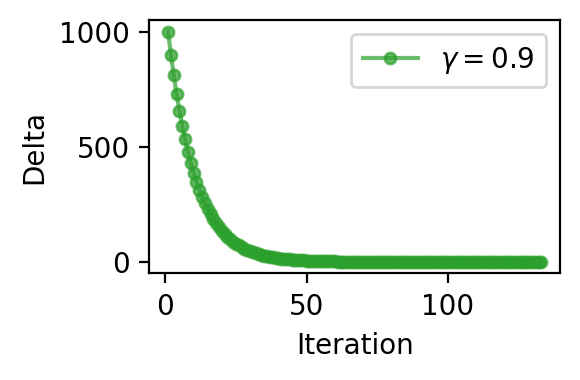

<ipython-input-1-957e55c40855>:147: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


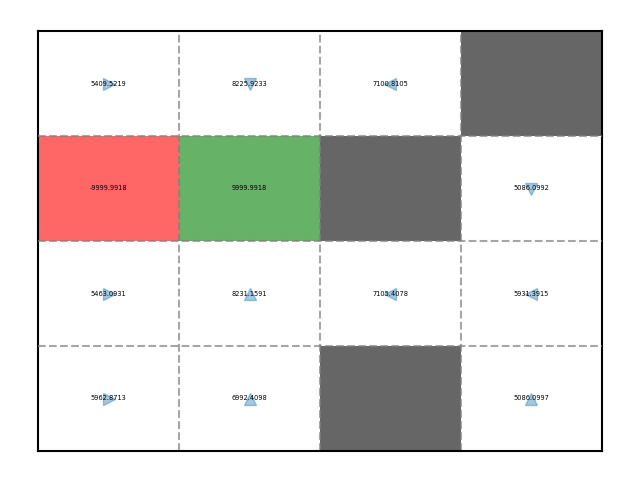

In [ ]:
import numpy as np

wumpus_problem = WumpusWorld('wumpusWorld.csv', reward = {0: -100, 1: 1000, 2: -1000, 3: np.NaN}, random_rate=0.2)

solution = ValuteIteration(wumpus_problem.reward_function, wumpus_problem.transition_model, gamma =0.9 )

solution.train()

wumpus_problem.visualize_value_policy(policy = solution.policy, values = solution.values)
#wumpus_problem.random_start_policy(solution.policy, (3,3), 1000, True)

# New Section